In [ ]:
!pip install -q segmentation-models
!pip install -q gdown
!pip install -q visualkeras
!pip install -q lapixdl

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1bgr1ES1PRhTZTR3pKwT8DxQxCGYtKfZM'
output = 'ds_for_python.tar.gz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1bgr1ES1PRhTZTR3pKwT8DxQxCGYtKfZM
To: /content/ds_for_python.tar.gz
100%|██████████| 68.8M/68.8M [00:00<00:00, 94.1MB/s]


'ds_for_python.tar.gz'

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
PROJECT_FOLDER = '/content/gdrive/My Drive/ds/Spectrum_Sensing/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#!wget -O ds_for_python.tar.gz https://drive.google.com/1bgr1ES1PRhTZTR3pKwT8DxQxCGYtKfZM/view?usp=sharing
!tar -xzf ds_for_python.tar.gz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar:

In [ ]:
import scipy.io
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import os
import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import visualkeras
from lapixdl.evaluation.evaluate import evaluate_segmentation
from scipy.linalg import norm
from sklearn.metrics import mean_squared_error
import random
import traceback

from matplotlib.colors import ListedColormap

import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
MAT_DS_FOLDER = 'ds_for_python/'
X = []
Y = []
Y_hat = []
TRAIN_MODEL = False

In [ ]:
def convert_to_int(filename):
    conv_dict = {'NR':0,'LTE':1,'Noise':2}
    f = open(filename,'r')
    f_tmp = open('tmp.txt','w')
    for line in f:
        line_tmp = line
        for key, value in conv_dict.items():
            line_tmp = line_tmp.replace(key,str(value))
        f_tmp.write(line_tmp)
    f_tmp.flush()
    f_tmp.close()
    
    val=pd.read_csv('tmp.txt', sep=',',header=None).values
    return val

In [ ]:
for idx in tqdm(range(1,609)):
    inp = scipy.io.loadmat(MAT_DS_FOLDER + 'rcvdSpectrogram-' + str(idx) + '.mat')['rcvdSpectrogram']
    pred = convert_to_int(MAT_DS_FOLDER + 'predictedLabels-' + str(idx) + '.csv')
    real = convert_to_int(MAT_DS_FOLDER + 'trueLabels-' + str(idx) + '.csv')
    
    X.append(inp)
    Y.append(real)

  0%|          | 0/608 [00:00<?, ?it/s]

In [ ]:
CLASSES = ['NR', 'LTE', 'Noise']

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.33, random_state=42)

x_train = np.array(x_train).astype(int)
x_val = np.array(x_val).astype(int)

y_train = np.array(y_train).astype(int)
y_val = np.array(y_val).astype(int)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')

es = EarlyStopping(
    monitor='loss', 
    patience=20,
    restore_best_weights=True,
    min_delta=0.000001, 
    verbose=1,
    mode='min'
)

mc = ModelCheckpoint(filepath=PROJECT_FOLDER + 'model.hdf5', 
                      monitor='loss',
                      verbose=1, 
                      save_best_only=True,
                      mode='min')

85532672/85521592 [==============================] - 2s 0us/step


In [ ]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model = keras.models.load_model(PROJECT_FOLDER + 'model.hdf5', compile=False)
model.compile(
    'rmsprop',
    #loss=sm.losses.bce_jaccard_loss,
    #loss=sm.losses.JaccardLoss(),
    loss='categorical_crossentropy',
    #loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #metrics=[sm.metrics.iou_score],
    metrics=['accuracy'],
)
if TRAIN_MODEL:
  hist = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=300,
      verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[es,mc]
  )

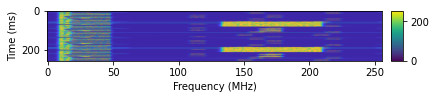

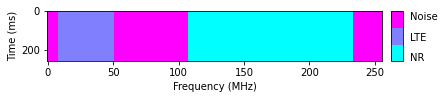

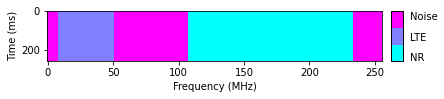

0 masks [00:00, ? masks/s]

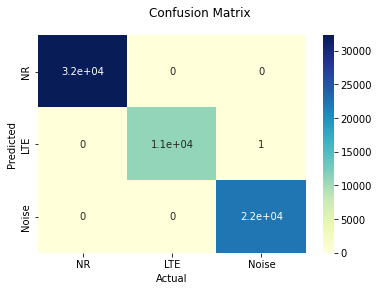

In [ ]:
cmp = ListedColormap(['#00FFFF', '#8080FF', '#FF00FF'])
for i in range(1):
  input_idx = np.random.randint(low=0,high=x_train.shape[0])

  input_img = x_train[input_idx:input_idx+1]
  real_output = y_train[input_idx:input_idx+1]

  y_pred = model.predict(input_img)
  y_pred_conv = np.round(y_pred*2.0)

  fig = plt.figure()
  ax = fig.add_subplot(111)
  heatmap = plt.imshow(input_img.reshape((256,256,3)).astype(int))
  plt.ylabel('Time (ms)')
  plt.xlabel('Frequency (MHz)')
  ax.set_aspect(0.15)
  cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
  plt.colorbar(heatmap, cax=cax)
  plt.savefig(PROJECT_FOLDER + 'input_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111)
  heatmap = plt.imshow(real_output.reshape((256,256)), cmap=cmp)
  plt.ylabel('Time (ms)')
  plt.xlabel('Frequency (MHz)')
  ax.set_aspect(0.15)
  cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
  cbar = plt.colorbar(heatmap, cax=cax)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(CLASSES):
      cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
  cbar.ax.get_yaxis().labelpad = 15
  plt.savefig(PROJECT_FOLDER + 'real_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111)
  heatmap = plt.imshow(y_pred_conv.reshape((256,256)), cmap=cmp)
  plt.ylabel('Time (ms)')
  plt.xlabel('Frequency (MHz)')
  ax.set_aspect(0.15)
  cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
  cbar = plt.colorbar(heatmap, cax=cax)
  cbar = plt.colorbar(heatmap, cax=cax)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(CLASSES):
      cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
  cbar.ax.get_yaxis().labelpad = 15
  plt.savefig(PROJECT_FOLDER + 'pred_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

  eval = evaluate_segmentation(real_output.reshape((256,256)), y_pred_conv.reshape((256,256)), CLASSES)
  fig, axes = eval.show_confusion_matrix()
  fig.savefig(PROJECT_FOLDER + 'cm_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

In [ ]:
import tensorflow as tf
m = tf.keras.metrics.MeanIoU(num_classes=3)

total_iou = 0.0
iou_list = []
df_eval_list = None
idx = 0
for input_idx in tqdm(range(x_val.shape[0])):
  input_img = x_val[input_idx:input_idx+1]
  real_output = y_val[input_idx:input_idx+1]
  
  y_pred = model.predict(input_img)
  y_pred_conv = np.round(y_pred*2.0)

  m.update_state(real_output.reshape((256,256)), y_pred_conv.reshape((256,256)))
  total_iou = total_iou + m.result().numpy()
  iou_list.append(m.result().numpy())
  m.reset_state()

  '''
  eval = evaluate_segmentation(real_output.reshape((256,256)), y_pred_conv.reshape((256,256)), CLASSES)
  if idx == 0:
    df_eval_list = eval.to_dataframe().astype(np.float64).fillna(0)
    idx = 1
  else:
    df_eval_list = df_eval_list.add(eval.to_dataframe().astype(np.float64).fillna(0), fill_value=0)
  '''

avg_iou = total_iou / x_train.shape[0]
print('avg_iou',avg_iou)


  0%|          | 0/201 [00:00<?, ?it/s]

avg_iou 0.4692993177425949


In [ ]:
#df_eval_list
#eval.to_dataframe().astype(np.float64)
#df_eval_list
'''
df=(df_eval_list/x_val.shape[0]).round(6)
df
ltx = df.to_latex(index=True)
f =open('results.txt','w')
f.write(ltx)
f.close()
'''

"\ndf=(df_eval_list/x_val.shape[0]).round(6)\ndf\nltx = df.to_latex(index=True)\nf =open('results.txt','w')\nf.write(ltx)\nf.close()\n"

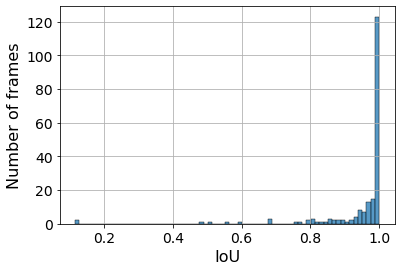

In [ ]:
import seaborn as sns
df_iou_list = pd.DataFrame({'IoU':iou_list})
sns.histplot(data=df_iou_list, x="IoU")
plt.xlabel('IoU', size=16)
plt.ylabel('Number of frames', size=16)
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14) 
plt.grid()
plt.show()

# Adversarial machine learning

In [ ]:
!pip install -q cleverhans
!pip install -q plot_keras_history

     |████████████████████████████████| 92 kB 132 kB/s 
     |████████████████████████████████| 42 kB 833 kB/s 
     |████████████████████████████████| 154 kB 47.2 MB/s 
     |████████████████████████████████| 323 kB 16.1 MB/s 


In [ ]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method

from tqdm.keras import TqdmCallback
from plot_keras_history import plot_history

from itertools import product
from random import shuffle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

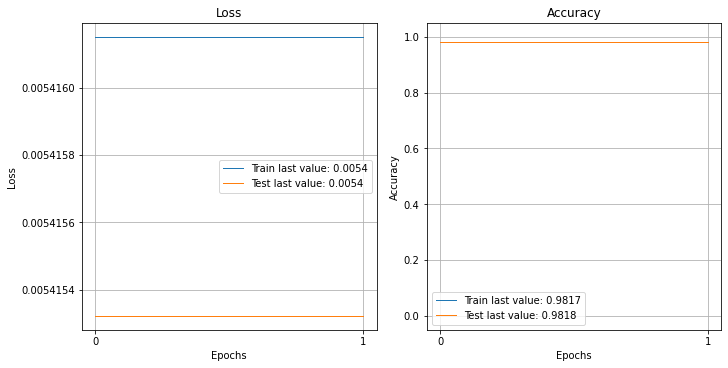

In [ ]:
from keras.layers import Dense, Conv2D, Flatten
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

model_copy = tf.keras.models.clone_model(model)
for layer in model_copy.layers:
    	layer.trainable = False

#model_vuln = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
#model_vuln.add(model_copy)
fc1 = Dense(100, activation='relu')(model_copy.output)
fc2 = Dense(100, activation='relu')(fc1)
fc3 = Dense(2,   activation='softmax')(fc2)

model_copy = tf.keras.Model(model_copy.input, fc3)

model_copy.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

y_dummy = np.zeros((x_train.shape[0],256,256,2))
mid_range = np.int(x_train.shape[0] / 2.0)
y_dummy[0:mid_range,0]= 1.0
y_dummy[mid_range:,1]= 1.0

es_copy = EarlyStopping(
    monitor='loss', 
    patience=20,
    restore_best_weights=True,
    min_delta=0.000001, 
    verbose=1,
    mode='min'
)

mc_copy = ModelCheckpoint(filepath=PROJECT_FOLDER + 'model_copy.hdf5', 
                      monitor='loss',
                      verbose=1, 
                      save_best_only=True,
                      mode='min')
     
history = model_copy.fit(x_train, y_dummy, epochs=2, verbose=0,
              callbacks=[TqdmCallback(verbose=1),es_copy],batch_size=12,
              validation_split=0.33, shuffle= True)
plot_history(history.history)
plt.show()

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [ ]:
#new_model.summary()

In [ ]:
logits_model = tf.keras.Model(model_copy.input, model_copy.output)
attacks = ['FGSM','BIM','MIM','PGD','CW']
attacks = ['FGSM','BIM','PGD']
#attacks = ['PGD']
eps_vals = np.round([0.05*255, 0.1*255, 0.15*255, 0.2*255, 0.25*255])
eps_vals = np.round([0.25*255])
params_list = list(product(eps_vals,attacks))

random.shuffle(params_list)

y_dummy = np.ones((1,256,256)).astype(int)

mal_diff_distance_list = []
real_mse_list = []
mal_mse_list = []
mal_predicted_diff_list = []
attack_name_list = []
eps_val_list = []

df_eval_list = None
idx = 0

#for i in tqdm(range(x_train.shape[0])):
for _ in tqdm(range(1)):
  i = np.random.randint(0,x_train.shape[0])
  test_input = x_train[i:i+1,:]
  test_output = y_train[i,:]

  for eps_val, attack in params_list:
    try:
      print('attack  :', attack)
      print('eps_val :', eps_val)
      
      if attack == 'FGSM':
        mal_input = fast_gradient_method(logits_model, test_input, y=y_dummy, eps=eps_val/20.0, norm=np.inf,
                                          clip_min=test_input.min(),clip_max=test_input.max(),
                                          targeted=False)
        mal_input = mal_input.numpy()
      elif attack == 'BIM':
        mal_input = basic_iterative_method(logits_model, test_input, y=y_dummy, eps=eps_val, norm=np.inf,
                                            #clip_min=test_input.min(),clip_max=test_input.max(),
                                            eps_iter=0.01,nb_iter=2000,
                                            targeted=False)
        mal_input = mal_input.numpy()
      elif attack == 'MIM':
        mal_input = momentum_iterative_method(logits_model, test_input, y=y_dummy, eps=eps_val, norm=np.inf,
                                                #clip_min=test_input.min(),clip_max=test_input.max(),
                                                eps_iter=0.01,nb_iter=2000,
                                                targeted=False)
        mal_input = mal_input.numpy()
      elif attack == 'PGD':
        mal_input = projected_gradient_descent(logits_model, test_input, y=y_dummy, eps=eps_val, norm=np.inf,
                                                clip_min=test_input.min(),clip_max=test_input.max(),
                                                eps_iter=0.01,nb_iter=2000,
                                                targeted=False)
        mal_input = mal_input.numpy()
      elif attack == 'CW':
        y_dummy_cw = np.ones((1,256,256,2)).astype(int)
        mal_input = carlini_wagner_l2(logits_model, test_input.astype(np.float32), y=y_dummy_cw,
                              targeted=False, #y=y_output,
                              batch_size=512, confidence=10.0,
                              abort_early=False, max_iterations=1000,
                              clip_min=test_input.min(),clip_max=test_input.max())
        
      prev_test_input = test_input
      prev_test_output = test_output
      mal_diff = mal_input.reshape(256,256,3) - test_input[0,:,:,:].reshape(256,256,3)

      mal_diff_distance = np.linalg.norm(mal_diff[0,:,:], ord = np.inf)
      mal_diff_distance_list.append(mal_diff_distance)
      #print('mal_diff_distance',mal_diff_distance)

      
      test_output = model.predict(test_input)
      real_mse = mean_squared_error(real_output.reshape(256,256),test_output.reshape(256,256))
      real_mse_list.append(real_mse)

      malicious_test_output = model.predict(mal_input)
      mal_mse = mean_squared_error(real_output.reshape(256,256),malicious_test_output.reshape(256,256))
      mal_mse_list.append(mal_mse)

      mal_predicted_diff = malicious_test_output.reshape(256,256) - test_output.reshape(256,256)
      mal_predicted_diff = np.linalg.norm(mal_predicted_diff, ord = np.inf)
      mal_predicted_diff_list.append(mal_predicted_diff)

      attack_name_list.append(attack)
      eps_val_list.append(eps_val)

      df_tmp = pd.DataFrame({'Malicious_Distance':[mal_diff_distance],
                        'Real_Predicted_MSE':[real_mse],
                        'Malicious_Predicted_MSE':[mal_mse],
                        'MalOut_RealOut_Diff':[mal_predicted_diff],
                        'Attack':[attack],
                        'eps':[eps_val]})
      df_tmp.to_csv(PROJECT_FOLDER + 'spectrum_sesning.csv', mode='a', header=False, index=False)

      eval = evaluate_segmentation(test_output.reshape((256,256)), malicious_test_output.reshape((256,256)), CLASSES)
      '''
      if idx == 0:
        df_eval_list = eval.to_dataframe()
        idx = idx + 1
      else:
        df_eval_list = df_eval_list.add(eval.to_dataframe())
      if idx > 1:
        vertical_concat = pd.concat(df_eval_list, axis=0)
      else:
        vertical_concat = df_eval_list
      vertical_concat.to_csv(PROJECT_FOLDER + 'spectrum_sensing_iou_res.csv', mode='w', header=True, index=True)
      '''
      df_eval_list = eval.to_dataframe()
      df_eval_list.to_csv(PROJECT_FOLDER + 'spectrum_sensing_iou_res-' + attack + '-' + str(eps_val) + '.csv', mode='a', header=False, index=True)
    except Exception:
      traceback.print_exc()

NameError: ignored

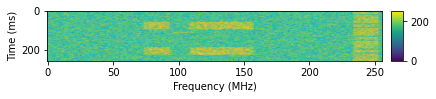

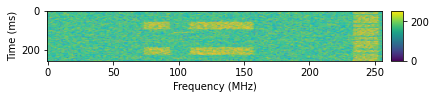

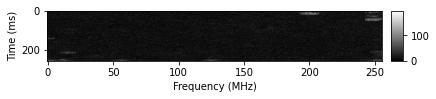

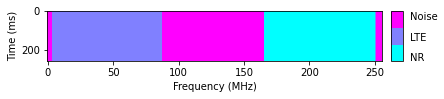

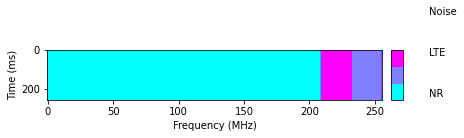

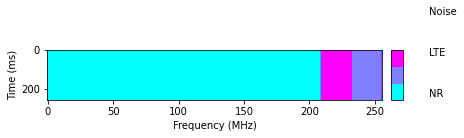

In [ ]:
from skimage import color

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(test_input.reshape((256,256,3)).astype(int))
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(heatmap, cax=cax)
#plt.savefig(PROJECT_FOLDER + 'input_' + str(i) + '.pdf' ,bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(mal_input.reshape((256,256,3)).astype(int))
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(heatmap, cax=cax)
#plt.savefig(PROJECT_FOLDER + 'input_' + str(i) + '.pdf' ,bbox_inches='tight')
plt.show()

diff_image = np.abs(test_input.reshape((256,256,3)) - mal_input.reshape((256,256,3)))
diff_image = diff_image * np.floor(255.0/diff_image.max())
diff_image = color.rgb2gray(diff_image)
diff_image = diff_image * np.floor(255.0/diff_image.max())

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(diff_image.reshape((256,256)).astype(int), cmap='gray')
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
plt.colorbar(heatmap, cax=cax)
#plt.savefig(PROJECT_FOLDER + 'input_' + str(i) + '.pdf' ,bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(real_output.reshape((256,256)), cmap=cmp)
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(heatmap, cax=cax)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(CLASSES):
    cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
cbar.ax.get_yaxis().labelpad = 15
#plt.savefig(PROJECT_FOLDER + 'real_' + str(i) + '.pdf' ,bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(test_output.reshape((256,256)), cmap=cmp)
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(heatmap, cax=cax)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(CLASSES):
    cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
cbar.ax.get_yaxis().labelpad = 15
#plt.savefig(PROJECT_FOLDER + 'real_' + str(i) + '.pdf' ,bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
heatmap = plt.imshow(malicious_test_output.reshape((256,256)), cmap=cmp)
plt.ylabel('Time (ms)')
plt.xlabel('Frequency (MHz)')
ax.set_aspect(0.15)
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(heatmap, cax=cax)
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(CLASSES):
    cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
cbar.ax.get_yaxis().labelpad = 15
#plt.savefig(PROJECT_FOLDER + 'real_' + str(i) + '.pdf' ,bbox_inches='tight')
plt.show()



In [ ]:
diff_image